<a href="https://colab.research.google.com/github/deebuls/devblog/blob/master/_notebooks/2023-01-26-Error-Correcting-Output-Codes-.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Error Correcting Output codes

## Paper reading

### Error Correcting Output Codes Improve Probability Estimation and Adversarial Robustness of Deep Neural Networks
* neurips link : https://proceedings.neurips.cc/paper/2019/hash/cd61a580392a70389e27b0bc2b439f49-Abstract.html
* code : https://github.com/Gunjan108/robust-ecoc

## Meta Review
This paper proposes the use of error correcting codes as class representations to improve robustness for adversarial attacks.  The main idea of error correcting output codes is well-known, but this is the paper that shows that such ideas can be used for adversarial robustness.  The paper shows very promising results especially in the rebuttal for CIFAR10.   The distance bound is equivalent to Plotkin as the reviewer pointed out so this should be fixed in the paper.  

## Contributions

* The paper demonstrates why standard one-hot encoding is susceptible to adversarial and fooling examples and prone to overconfident probability estimates.
* It also demonstrate that well-chosen error-correcting output codes, coupled with a modified decoding strategy, leads to an intrinsically more robust system that also yields better probabillity estimates.
* How Softmax is prone to attack as compared to sigmoid and tanh

## Reviewer 3
The region of uncertainty (prediction probability close to 0.5) for softmax of logits is extremely small near an M-1 dimensional hyperplane in the logits space. The reason is changing one of the logits for one of the classes affects the probability vectors in all dimensions.   The authors show that, if each logit is first converted to an independent probability using 1/(1+exp(-x)) function and the probability vector correlated with each codeword of an error correcting in a soft way to decode, this method has a large volume of uncertainty. The volume of uncertainty is larger when the min hamming distance of the code is large. This because multiple logits must be changed at the same time to cause a wrong decoding.   Authors demonstrate this with nice plots. Authors propose to use subset of rows of Hamming Matrix for two properties: They have almost the best minimum hamming distance  (half the dimension of the code) and they are orthogonal (which is important for unconfused decoding). They derive an upper bound on distance for any code.  I checked the proof of the upper bound - it seems correct.  Then the authors demonstrate performance (using Hamming 16 code) against PGD and Carlini Wagner attacks. 

## Ploting Figure 1

In [1]:
import numpy as np
import torch

In [2]:
import matplotlib.pyplot as plt

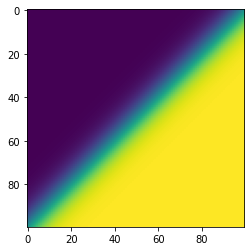

In [21]:
samples = 100
z0 = np.linspace(-10, 10, samples)
z1 = np.linspace(10, -10, samples)
xv, yv = np.meshgrid(z0, z1)
t = torch.tensor([list(xv.ravel()),list(yv.ravel())])
t = t.permute(1,0)

softmax = torch.nn.functional.softmax(t, dim=1).numpy()
sigmoid = torch.sigmoid(t)
sigmoid = sigmoid/sigmoid.sum(dim=1, keepdim=True)

plt.imshow(softmax[:,0].reshape(samples,samples))

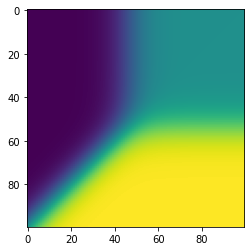

In [22]:
plt.imshow(sigmoid[:,0].reshape(samples,samples))

## Thin Green Region

* For Softmax the uncertain region (in green here) is thin, which basically means its easier to shift from one confident region to another.
* For sigmoid this region is huge. Its not exact replica of the paper beause the sigmoid is of range -10 to 10 and here its just -1 to 1 



# Hamming Distance

The Hamming distance between any two binary codewords x and y, denoted d(x, y), is simply
|x − y|0, where | · |0 denotes the L0 norm. 

$$ d = \min{d(x, y) : x, y ∈ C, x \neq y}  $$

* The standard one-hot coding scheme has a Hamming distance of only 2. 
* Practically, this means that if the adversary can sufficiently alter even a single logit, an error may occur. 
* In Figure above, changing a single logit (i.e. an axis-aligned perturbation) is sufficient to make the classifier uncertain. Ideally, we want the classifier to be robust to changes to multiple logits.


Below we use the linalg hadamard code and encode 10 numbers to a hadamard code with length 16  and comapr with on-hot-encoding . As you can see you need only to flip 1 bit to make it vulnerable.

In [11]:
import scipy.linalg

code_length = 16
num_codes = 10 #num classes
code_length_true = code_length

 Scipy hadamard  (16, 16)
 Replaces   (16, 16)
final  (10, 16)
[[ 1.  1.  1. -1. -1. -1.  1. -1. -1.  1.  1.  1. -1.  1. -1. -1.]
 [-1. -1.  1. -1.  1. -1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1.  1.  1. -1.  1. -1.]
 [-1.  1. -1. -1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1.]
 [ 1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1.]
 [-1.  1.  1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.]
 [-1. -1.  1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.]
 [-1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.]]


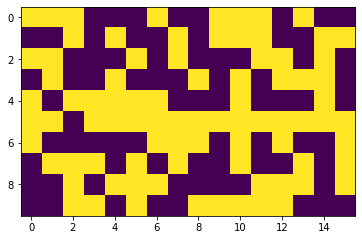

In [23]:
M = scipy.linalg.hadamard(code_length).astype(np.float32)
print ( " Scipy hadamard ", M.shape)
M[np.arange(0, num_codes,2), 0]= -1#replace first col, which for this Hadamard construction is always 1, hence not a useful bit
print ( " Replaces  ", M.shape)
np.random.seed(12754); np.random.shuffle(M)
idx=np.random.permutation(code_length)
M = M[0:num_codes, idx[0:code_length_true]]
print ("final ", M.shape)
print (M)
plt.imshow(M)
plt.savefig("error_correcting_output_codes.png")

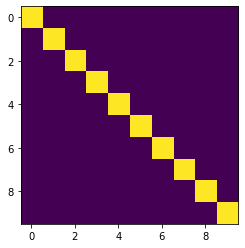

In [20]:
#One hot encoding 
plt.imshow(np.eye(10))

# Conclusion

We have presented a simple approach to improving model robustness that is centered around three
core ideas. 
* One, moving from softmax to sigmoid decoding means that a non-trivial volume of the Euclidean logit space is now allocated towards model uncertainty. In crafting convincing adversarial perturbations, the adversary must now guard against landing in such regions, i.e. his attack surface is smaller.
* Two, in changing the set of codewords from IM to one with larger Hamming distance, the Euclidean distance in logit space between any two regions of high probability for any given class becomes larger. This means that the adversary’s perturbations now need to be larger in magnitude to attain the same level of confidence. 
* Three, in learning output bits with multiple disjoint networks,
we reduce correlations between outputs. Such correlations are implicitly capitalized on by common attack algorithms. This is because many attacks search for a perturbation by following the loss gradient, and the loss will commonly increase most rapidly in directions where the perturbation impacts multiple (correlated) logits simultaneously. Importantly, since it simply alters the output encoding but otherwise uses completely standard architectural components (i.e., convolutional and densely connected layers), the primary source of our approach’s robustness does not appear to be
obfuscated gradients [15].